# XGBoost 개요
### eXtra Gradient Boost

캐글같은 컴피티션에서 많이 활용되면서 분석가들한테 많이 사용됐었었다. 
* 분류 뿐만 아니라 회귀에서도 많이 사용.  
* GBM 대비 빠르다는거지 lightGBM 보다 좀 더 느리고 다른 앙상블계열보단 느리나 GPU를 지원.
* 규제(Regularization) 기능 탑재: 일반 GBM에는 없었다.
* Tree Pruning: 사이킷런의 GBM에서는 없었다. Pruning= 가지치기. 노드들을 다 만들었다가 다시 한번 이 트리들이 제대로 역할을 하는가 검증.


![XGBoost1](img/XGBoost1.png)



## XGBoost 파이썬 구현

![XGPY](img/XGPY.png)



## XGBoost 파이썬 래퍼와 사이킷런 래퍼 API 비교

파이썬 래퍼를 어느정도 이해해야 나중에 사이킷런 래퍼 이해가 편하다.  
뒤의 파라미터같은걸 파이썬에서 그대로 가져온게 많음.  

가장 큰 차이는 파이썬 래퍼에서는 DMatrix 객체를 별도로 생성한다.

![XGPY1](img/XGPY1.png)



## XGBoost 파이썬 래퍼와 사이킷런 래퍼 하이퍼 파라미터 비교

트리 기반의 앙상블은 하이퍼 파라미터가 많은데, XGBoost는 기능들이 더 많아서 하이퍼 파라미터도 더 많다.  
하이퍼 파라미터 튜닝에 너무 시간을 들일 필요없다. 너~무 많아서 시간이 너무 오래걸리기 때문.  
규칙을 보면 일단 파이썬 래퍼가 더 먼저 만들어졌는데, 사이킷런 래퍼에서는  
기존의 GBM에 파이썬 래퍼의 하이퍼파라미터와 동일한 역할을 하는게 있으면 GBM 하이퍼 파라미터를 그대로 쓴다. 

min_child_weight는 weight값이 특정값이 넘으면 child를 만들거냐 안만들거냐라는걸 뜻하는게 min_child_weight이다.

XGBoost는 Regularization이 된다. 이게 뭐냐면 오차를 줄이기 위해 계속 학습을 하다보면 학습에만 몰두하게 되어서  
오버피팅이 나오게 될 확률이 많다. 그래서 오히려 오차에 너무 집중하지 않도록 제약을 거는 것임.

colsample_bytree는 학습할때 전체 피쳐말고 일부 피쳐만 학습할 수 있다.(GBM의 max_feature 처럼)  
근데 XGBoost는 좀더 상세화 되어있다. tree를 만들때 컬럼을 어느 정도 비율로 만들 것이냐.  
또 여기 다른 파라미터가 두가지 있는데 bynode, bysplit으로 노드를 만들때, 스플릿할때 어느정도 컬럼 샘플을 할거냐.

gamma는 손실을 계속 줄여야되는데 어느정도 손실이 줄이지 않으면 트리의 리프노드를 추가로 분할하지 않는 파라미터다.

![XGBcompare1](img/XGBcompare1.png)
![XGBcompare2](img/XGBcompare2.png)



## XGBoost 조기 중단 기능(Early Stopping)

![EarlyStopping](img/EarlyStopping.png)

* XGBoost 버전 확인

In [1]:
import xgboost

print(xgboost.__version__)

0.90


### 파이썬 래퍼 XGBoost 적용 – 위스콘신 Breast Cancer 데이터 셋

**데이터 세트 로딩**

In [3]:
import xgboost as xgb
from xgboost import plot_importance

import pandas as pd
import numpy as np
from sklearn.datasets import load_breast_cancer
from sklearn.model_selection import train_test_split
import warnings
warnings.filterwarnings('ignore')

dataset = load_breast_cancer()
X_features= dataset.data
y_label = dataset.target

cancer_df = pd.DataFrame(data=X_features, columns=dataset.feature_names)
cancer_df['target']= y_label
cancer_df.head(3)


#1이면 악성, 0이면 양성이라는 뜻

,mean radius,mean texture,mean perimeter,mean area,mean smoothness,mean compactness,mean concavity,mean concave points,mean symmetry,mean fractal dimension,...,worst texture,worst perimeter,worst area,worst smoothness,worst compactness,worst concavity,worst concave points,worst symmetry,worst fractal dimension,target
0,17.99,10.38,122.8,1001.0,0.11840,0.27760,0.3001,0.14710,0.2419,0.07871,...,17.33,184.6,2019.0,0.1622,0.6656,0.7119,0.2654,0.4601,0.11890,0
1,20.57,17.77,132.9,1326.0,0.08474,0.07864,0.0869,0.07017,0.1812,0.05667,...,23.41,158.8,1956.0,0.1238,0.1866,0.2416,0.1860,0.2750,0.08902,0
2,19.69,21.25,130.0,1203.0,0.10960,0.15990,0.1974,0.12790,0.2069,0.05999,...,25.53,152.5,1709.0,0.1444,0.4245,0.4504,0.2430,0.3613,0.08758,0


In [4]:
print(dataset.target_names)
print(cancer_df['target'].value_counts())

['malignant' 'benign']
1    357
0    212
Name: target, dtype: int64


In [5]:
# 전체 데이터 중 80%는 학습용 데이터, 20%는 테스트용 데이터 추출
X_train, X_test, y_train, y_test=train_test_split(X_features, y_label,
                                         test_size=0.2, random_state=156 )
print(X_train.shape , X_test.shape)


(455, 30) (114, 30)


**학습과 예측 데이터 세트를 DMatrix로 변환**

In [6]:
dtrain = xgb.DMatrix(data=X_train , label=y_train)
dtest = xgb.DMatrix(data=X_test , label=y_test)

**하이퍼 파라미터 설정**

In [7]:
params = { 'max_depth':3,
           'eta': 0.1,
           'objective':'binary:logistic',
           'eval_metric':'logloss',
           'early_stoppings':100
        }
num_rounds = 400 # 400번 돈다

**주어진 하이퍼 파라미터와 early stopping 파라미터를 train( ) 함수의 파라미터로 전달하고 학습**

In [8]:
# train 데이터 셋은 ‘train’ , evaluation(test) 데이터 셋은 ‘eval’ 로 명기합니다. 
wlist = [(dtrain,'train'),(dtest,'eval') ]


# 하이퍼 파라미터와 early stopping 파라미터를 train( ) 함수의 파라미터로 전달
xgb_model = xgb.train(params = params , dtrain=dtrain , num_boost_round=num_rounds , evals=wlist )

# params = params 
# num_boost_round 는 몇번 반복을 할거냐, 또는 약한 학습기가 몇번 있느냐는 뜻
# evaluation 데이터 세트를 이렇게wlist로 넣어줄 수 있다.  

# logloss 값이 쭉 떨어지는 걸 확인할 수 있음

[0]	train-logloss:0.609688	eval-logloss:0.61352
[1]	train-logloss:0.540803	eval-logloss:0.547842
[2]	train-logloss:0.483753	eval-logloss:0.494247
[3]	train-logloss:0.434457	eval-logloss:0.447986
[4]	train-logloss:0.39055	eval-logloss:0.409109
[5]	train-logloss:0.354145	eval-logloss:0.374977
[6]	train-logloss:0.321221	eval-logloss:0.345714
[7]	train-logloss:0.292592	eval-logloss:0.320529
[8]	train-logloss:0.267467	eval-logloss:0.29721
[9]	train-logloss:0.245153	eval-logloss:0.277991
[10]	train-logloss:0.225694	eval-logloss:0.260302
[11]	train-logloss:0.207937	eval-logloss:0.246037
[12]	train-logloss:0.192184	eval-logloss:0.231556
[13]	train-logloss:0.177916	eval-logloss:0.22005
[14]	train-logloss:0.165222	eval-logloss:0.208572
[15]	train-logloss:0.153622	eval-logloss:0.199993
[16]	train-logloss:0.14333	eval-logloss:0.190118
[17]	train-logloss:0.133985	eval-logloss:0.181818
[18]	train-logloss:0.125599	eval-logloss:0.174729
[19]	train-logloss:0.117286	eval-logloss:0.167657
[20]	train-logl

[164]	train-logloss:0.0072	eval-logloss:0.087777
[165]	train-logloss:0.00718	eval-logloss:0.087517
[166]	train-logloss:0.007161	eval-logloss:0.087542
[167]	train-logloss:0.007142	eval-logloss:0.087642
[168]	train-logloss:0.007122	eval-logloss:0.08739
[169]	train-logloss:0.007103	eval-logloss:0.087377
[170]	train-logloss:0.007084	eval-logloss:0.087298
[171]	train-logloss:0.007065	eval-logloss:0.087368
[172]	train-logloss:0.007047	eval-logloss:0.087395
[173]	train-logloss:0.007028	eval-logloss:0.087385
[174]	train-logloss:0.007009	eval-logloss:0.087132
[175]	train-logloss:0.006991	eval-logloss:0.087159
[176]	train-logloss:0.006973	eval-logloss:0.086955
[177]	train-logloss:0.006955	eval-logloss:0.087053
[178]	train-logloss:0.006937	eval-logloss:0.08697
[179]	train-logloss:0.00692	eval-logloss:0.086973
[180]	train-logloss:0.006901	eval-logloss:0.087038
[181]	train-logloss:0.006884	eval-logloss:0.086799
[182]	train-logloss:0.006866	eval-logloss:0.086826
[183]	train-logloss:0.006849	eval-log

[326]	train-logloss:0.005354	eval-logloss:0.08578
[327]	train-logloss:0.005348	eval-logloss:0.085857
[328]	train-logloss:0.005342	eval-logloss:0.085939
[329]	train-logloss:0.005336	eval-logloss:0.085825
[330]	train-logloss:0.00533	eval-logloss:0.085869
[331]	train-logloss:0.005324	eval-logloss:0.085893
[332]	train-logloss:0.005318	eval-logloss:0.085922
[333]	train-logloss:0.005312	eval-logloss:0.085842
[334]	train-logloss:0.005306	eval-logloss:0.085735
[335]	train-logloss:0.0053	eval-logloss:0.085816
[336]	train-logloss:0.005294	eval-logloss:0.085892
[337]	train-logloss:0.005288	eval-logloss:0.085936
[338]	train-logloss:0.005283	eval-logloss:0.08583
[339]	train-logloss:0.005277	eval-logloss:0.085909
[340]	train-logloss:0.005271	eval-logloss:0.085831
[341]	train-logloss:0.005265	eval-logloss:0.085727
[342]	train-logloss:0.00526	eval-logloss:0.085678
[343]	train-logloss:0.005254	eval-logloss:0.085721
[344]	train-logloss:0.005249	eval-logloss:0.085796
[345]	train-logloss:0.005243	eval-log

**predict()를 통해 예측 확률값을 반환하고 예측 값으로 변환**

In [9]:
pred_probs = xgb_model.predict(dtest)
print('predict( ) 수행 결과값을 10개만 표시, 예측 확률 값으로 표시됨')
print(np.round(pred_probs[:10],3))

# 예측 확률이 0.5 보다 크면 1 , 그렇지 않으면 0 으로 예측값 결정하여 List 객체인 preds에 저장 
preds = [ 1 if x > 0.5 else 0 for x in pred_probs ]
print('예측값 10개만 표시:',preds[:10])

predict( ) 수행 결과값을 10개만 표시, 예측 확률 값으로 표시됨
[0.95  0.003 0.9   0.086 0.993 1.    1.    0.999 0.998 0.   ]
예측값 10개만 표시: [1, 0, 1, 0, 1, 1, 1, 1, 1, 0]


**get_clf_eval( )을 통해 예측 평가**

In [10]:
from sklearn.metrics import confusion_matrix, accuracy_score
from sklearn.metrics import precision_score, recall_score
from sklearn.metrics import f1_score, roc_auc_score

# 수정된 get_clf_eval() 함수 
def get_clf_eval(y_test, pred=None, pred_proba=None):
    confusion = confusion_matrix( y_test, pred)
    accuracy = accuracy_score(y_test , pred)
    precision = precision_score(y_test , pred)
    recall = recall_score(y_test , pred)
    f1 = f1_score(y_test,pred)
    # ROC-AUC 추가 
    roc_auc = roc_auc_score(y_test, pred_proba)
    print('오차 행렬')
    print(confusion)
    # ROC-AUC print 추가
    print('정확도: {0:.4f}, 정밀도: {1:.4f}, 재현율: {2:.4f},\
    F1: {3:.4f}, AUC:{4:.4f}'.format(accuracy, precision, recall, f1, roc_auc))

In [11]:
get_clf_eval(y_test , preds, pred_probs)

오차 행렬
[[35  2]
 [ 1 76]]
정확도: 0.9737, 정밀도: 0.9744, 재현율: 0.9870,    F1: 0.9806, AUC:0.9951


**Feature Importance 시각화**

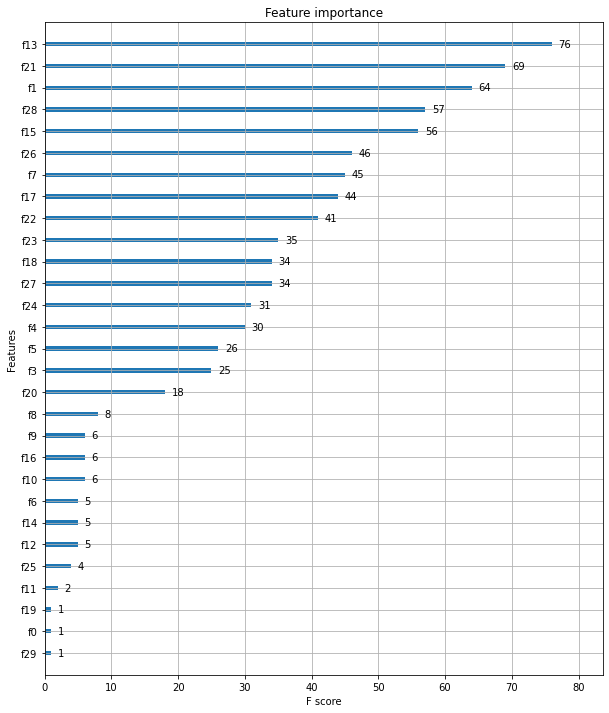

In [12]:
import matplotlib.pyplot as plt
%matplotlib inline

fig, ax = plt.subplots(figsize=(10, 12))
plot_importance(xgb_model, ax=ax) 
# 인자: 학습이 된 xgb_model, 그리고 ax(축)을 넣어줘야함. subplot을 하면 하위의 축이 반환이 됨.
# 간단하게 이렇게 두 줄로 할 수 있다
# 알아서 중요도 순으로 위에서부터 나열을 시켜주는 시각화

### 사이킷런 Wrapper XGBoost 개요 및 적용 

**사이킷런 래퍼 클래스 임포트, 학습 및 예측**

In [13]:
# 사이킷런 래퍼 XGBoost 클래스인 XGBClassifier 임포트
from xgboost import XGBClassifier

# evaluation 세트를 불러준다. 원래는 검증 데이터셋을 넣어야되는데 여기선 오버피팅이 되어버림. 데이터 세트가 충분치 않아서 그냥 테스트 데이터로 실습
# 실제 테스트할 때는 이렇게 하면 안됨
evals = [(X_test, y_test)]

# 위에서 파이썬 래퍼했을 때랑 비슷한 파라미터를 주고 fit 에다가 early_stopping을 해야함. eval_set에 evaluation 데이터 셋을 넣어줌.
# eval_metric="logloss"는 손실함수는 로그함수를 쓰겠다는 뜻.
xgb_wrapper = XGBClassifier(n_estimators=400, learning_rate=0.1, max_depth=3)
xgb_wrapper.fit(X_train , y_train,  early_stopping_rounds=400,eval_set=evals, eval_metric="logloss",  verbose=True)

w_preds = xgb_wrapper.predict(X_test)
w_pred_proba = xgb_wrapper.predict_proba(X_test)[:, 1]


[0]	validation_0-logloss:0.61352
Will train until validation_0-logloss hasn't improved in 400 rounds.
[1]	validation_0-logloss:0.547842
[2]	validation_0-logloss:0.494247
[3]	validation_0-logloss:0.447986
[4]	validation_0-logloss:0.409109
[5]	validation_0-logloss:0.374977
[6]	validation_0-logloss:0.345714
[7]	validation_0-logloss:0.320529
[8]	validation_0-logloss:0.29721
[9]	validation_0-logloss:0.277991
[10]	validation_0-logloss:0.260302
[11]	validation_0-logloss:0.246037
[12]	validation_0-logloss:0.231556
[13]	validation_0-logloss:0.22005
[14]	validation_0-logloss:0.208572
[15]	validation_0-logloss:0.199993
[16]	validation_0-logloss:0.190118
[17]	validation_0-logloss:0.181818
[18]	validation_0-logloss:0.174729
[19]	validation_0-logloss:0.167657
[20]	validation_0-logloss:0.158202
[21]	validation_0-logloss:0.154725
[22]	validation_0-logloss:0.148947
[23]	validation_0-logloss:0.143308
[24]	validation_0-logloss:0.136344
[25]	validation_0-logloss:0.132778
[26]	validation_0-logloss:0.127912

[230]	validation_0-logloss:0.086002
[231]	validation_0-logloss:0.085922
[232]	validation_0-logloss:0.086102
[233]	validation_0-logloss:0.086115
[234]	validation_0-logloss:0.086169
[235]	validation_0-logloss:0.086263
[236]	validation_0-logloss:0.086292
[237]	validation_0-logloss:0.086217
[238]	validation_0-logloss:0.086395
[239]	validation_0-logloss:0.086342
[240]	validation_0-logloss:0.08618
[241]	validation_0-logloss:0.086195
[242]	validation_0-logloss:0.086248
[243]	validation_0-logloss:0.086263
[244]	validation_0-logloss:0.086293
[245]	validation_0-logloss:0.086222
[246]	validation_0-logloss:0.086398
[247]	validation_0-logloss:0.086347
[248]	validation_0-logloss:0.086276
[249]	validation_0-logloss:0.086448
[250]	validation_0-logloss:0.086294
[251]	validation_0-logloss:0.086312
[252]	validation_0-logloss:0.086364
[253]	validation_0-logloss:0.086394
[254]	validation_0-logloss:0.08649
[255]	validation_0-logloss:0.086441
[256]	validation_0-logloss:0.08629
[257]	validation_0-logloss:0.08

In [14]:
get_clf_eval(y_test , w_preds, w_pred_proba)

오차 행렬
[[35  2]
 [ 1 76]]
정확도: 0.9737, 정밀도: 0.9744, 재현율: 0.9870,    F1: 0.9806, AUC:0.9951


**early stopping을 100으로 설정하고 재 학습/예측/평가**

In [15]:
from xgboost import XGBClassifier

xgb_wrapper = XGBClassifier(n_estimators=400, learning_rate=0.1, max_depth=3)

evals = [(X_test, y_test)]
xgb_wrapper.fit(X_train, y_train, early_stopping_rounds=100, eval_metric="logloss", 
                eval_set=evals, verbose=True)

ws100_preds = xgb_wrapper.predict(X_test)
ws100_pred_proba = xgb_wrapper.predict_proba(X_test)[:, 1]

[0]	validation_0-logloss:0.61352
Will train until validation_0-logloss hasn't improved in 100 rounds.
[1]	validation_0-logloss:0.547842
[2]	validation_0-logloss:0.494247
[3]	validation_0-logloss:0.447986
[4]	validation_0-logloss:0.409109
[5]	validation_0-logloss:0.374977
[6]	validation_0-logloss:0.345714
[7]	validation_0-logloss:0.320529
[8]	validation_0-logloss:0.29721
[9]	validation_0-logloss:0.277991
[10]	validation_0-logloss:0.260302
[11]	validation_0-logloss:0.246037
[12]	validation_0-logloss:0.231556
[13]	validation_0-logloss:0.22005
[14]	validation_0-logloss:0.208572
[15]	validation_0-logloss:0.199993
[16]	validation_0-logloss:0.190118
[17]	validation_0-logloss:0.181818
[18]	validation_0-logloss:0.174729
[19]	validation_0-logloss:0.167657
[20]	validation_0-logloss:0.158202
[21]	validation_0-logloss:0.154725
[22]	validation_0-logloss:0.148947
[23]	validation_0-logloss:0.143308
[24]	validation_0-logloss:0.136344
[25]	validation_0-logloss:0.132778
[26]	validation_0-logloss:0.127912

[230]	validation_0-logloss:0.086002
[231]	validation_0-logloss:0.085922
[232]	validation_0-logloss:0.086102
[233]	validation_0-logloss:0.086115
[234]	validation_0-logloss:0.086169
[235]	validation_0-logloss:0.086263
[236]	validation_0-logloss:0.086292
[237]	validation_0-logloss:0.086217
[238]	validation_0-logloss:0.086395
[239]	validation_0-logloss:0.086342
[240]	validation_0-logloss:0.08618
[241]	validation_0-logloss:0.086195
[242]	validation_0-logloss:0.086248
[243]	validation_0-logloss:0.086263
[244]	validation_0-logloss:0.086293
[245]	validation_0-logloss:0.086222
[246]	validation_0-logloss:0.086398
[247]	validation_0-logloss:0.086347
[248]	validation_0-logloss:0.086276
[249]	validation_0-logloss:0.086448
[250]	validation_0-logloss:0.086294
[251]	validation_0-logloss:0.086312
[252]	validation_0-logloss:0.086364
[253]	validation_0-logloss:0.086394
[254]	validation_0-logloss:0.08649
[255]	validation_0-logloss:0.086441
[256]	validation_0-logloss:0.08629
[257]	validation_0-logloss:0.08

In [25]:
get_clf_eval(y_test , ws100_preds, ws100_pred_proba)

오차 행렬
[[34  3]
 [ 1 76]]
정확도: 0.9649, 정밀도: 0.9620, 재현율: 0.9870,    F1: 0.9744, AUC:0.9954


**early stopping을 10으로 설정하고 재 학습/예측/평가**

이렇게 짧게하면 최적화되기 전에 끝날 가능성이 있긴한데  
하이퍼 파라미터의 경우의 수까지 다 맞추겠다고 하면 정말 시간이 오래걸릴 수 있으므로  
빠르게 세팅하는 작업을 하고 싶은 경우 이렇게 활용하기도 한다.

In [16]:
# early_stopping_rounds를 10으로 설정하고 재 학습. 
xgb_wrapper.fit(X_train, y_train, early_stopping_rounds=10, 
                eval_metric="logloss", eval_set=evals,verbose=True)

ws10_preds = xgb_wrapper.predict(X_test)
ws10_pred_proba = xgb_wrapper.predict_proba(X_test)[:, 1]
get_clf_eval(y_test , ws10_preds, ws10_pred_proba)

[0]	validation_0-logloss:0.61352
Will train until validation_0-logloss hasn't improved in 10 rounds.
[1]	validation_0-logloss:0.547842
[2]	validation_0-logloss:0.494247
[3]	validation_0-logloss:0.447986
[4]	validation_0-logloss:0.409109
[5]	validation_0-logloss:0.374977
[6]	validation_0-logloss:0.345714
[7]	validation_0-logloss:0.320529
[8]	validation_0-logloss:0.29721
[9]	validation_0-logloss:0.277991
[10]	validation_0-logloss:0.260302
[11]	validation_0-logloss:0.246037
[12]	validation_0-logloss:0.231556
[13]	validation_0-logloss:0.22005
[14]	validation_0-logloss:0.208572
[15]	validation_0-logloss:0.199993
[16]	validation_0-logloss:0.190118
[17]	validation_0-logloss:0.181818
[18]	validation_0-logloss:0.174729
[19]	validation_0-logloss:0.167657
[20]	validation_0-logloss:0.158202
[21]	validation_0-logloss:0.154725
[22]	validation_0-logloss:0.148947
[23]	validation_0-logloss:0.143308
[24]	validation_0-logloss:0.136344
[25]	validation_0-logloss:0.132778
[26]	validation_0-logloss:0.127912


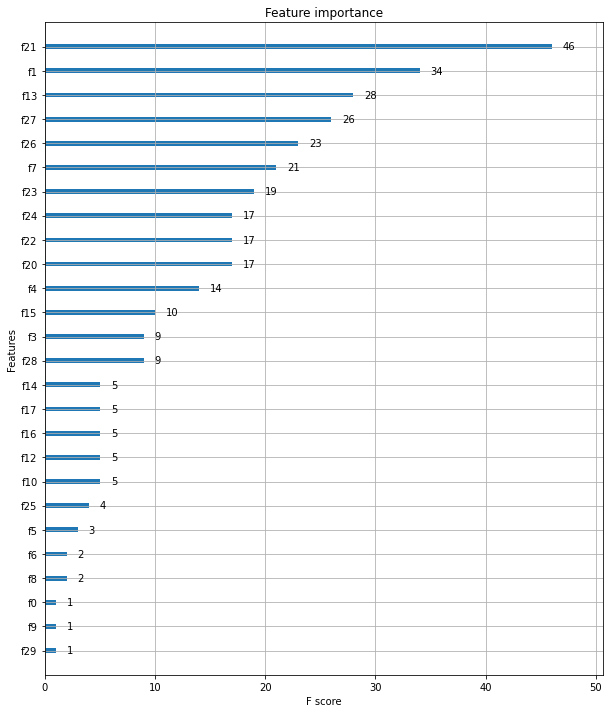

In [17]:
from xgboost import plot_importance
import matplotlib.pyplot as plt
%matplotlib inline

fig, ax = plt.subplots(figsize=(10, 12))
# 사이킷런 래퍼 클래스를 입력해도 무방. 
plot_importance(xgb_wrapper, ax=ax)